# Project 1: Content Moderation and Toxicity Classification

## Naive Bayes vs Logistic Regression

#### Imports

In [31]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import log_loss
from nltk.stem.wordnet import WordNetLemmatizer
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# Loading Train and Test Data

In [32]:
train_data = pd.read_csv("./train.csv")
test_data = pd.read_csv("./test.csv")
test_labels = pd.read_csv("./test_labels.csv")

train_labels = list(train_data.columns[2:])

print("train_data Shape = ",train_data.shape)
print("test_data shape = ",test_data.shape)
print("test_label shape = ",test_labels.shape)

train_data Shape =  (159571, 8)
test_data shape =  (153164, 2)
test_label shape =  (153164, 7)


# Preprocessing & Cleaning Data
<strong>Data Preprocessing Steps performed, such as:</strong>
 - Lowercasing the text
 - Removing punctuation, digits, and stop words
 - Lemmatizing words and dropping words with a length less than 3
 - Handling non-ASCII characters


<strong>For our current dataset TF-IDF with Logistic Regression/Naive Bayes had more advantages as compared to other approached:</strong>

Advantages:
- <strong>Interpretability</strong>: TF-IDF gives importance to words based on their frequency in the document and across the corpus. This offers a level of interpretability in understanding which words are crucial for classification.
- <strong>Efficiency</strong>: TF-IDF is computationally efficient and works reasonably well for smaller datasets or when the text lengths are not excessively long.
- <strong>Simplicity</strong>: The approach is straightforward to implement and understand. It's a popular choice for initial text classification tasks.

<strong>The dataset demonstrates a class imbalance between toxic and non-toxic comments.</strong>
To mitigate this issue, random sampling is employed between clean and unclean comments, ensuring a more balanced representation of both classes in the training data. This approach aids in preventing the model from being biased toward the majority class and enhances its ability to generalize to both toxic and non-toxic comments.


In [33]:
def tokenize(text):
    '''
    Tokenize text and return a non-unique list of tokenized words found in the text. 
    Normalize to lowercase, strip punctuation, remove stop words, filter non-ascii characters.
    Lemmatize the words and lastly drop words of length < 3.
    '''
    text = text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words = nopunct.split(' ')
    # remove any non ascii
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(w) for w in words]
    words = [w for w in words if len(w) > 2]
    return words

# Get column labels from the training data
column_labels = train_data.columns.tolist()[2:]

# Calculate the sum of occurrences for each toxic label and sort them
train_data[column_labels].sum().sort_values()

# the comment is tagged with at least one toxic label.
train_toxic = train_data[train_data[column_labels].sum(axis=1) > 0]
# has no toxic labels and is clean.
train_clean = train_data[train_data[column_labels].sum(axis=1) == 0]

# Randomly sample 16225 clean comments
train_clean_sampled = train_clean.sample(n=16225, random_state=42)

# Combine the toxic and sampled clean comments
dataframe = pd.concat([train_toxic, train_clean_sampled], axis=0)

# Shuffle the data to avoid any order bias during training
dataframe = dataframe.sample(frac=1, random_state=42)

# Extracting the 'comment_text' column as training texts
# train_texts = train_data['comment_text']
# train_labels = train_data.iloc[:,2:]


# Extracting features using TF-IDF vectorization
vector = TfidfVectorizer(ngram_range=(1, 1), analyzer='word',
                         tokenizer=tokenize, stop_words='english',
                         strip_accents='unicode', use_idf=1, min_df=10)

# Transform the training and test data using the TF-IDF vectorizer
X_train = vector.fit_transform(dataframe['comment_text']) #Training data
X_test = vector.transform(test_data['comment_text']) #Test data



# Clean vs Toxic Comments - Class Imbalances

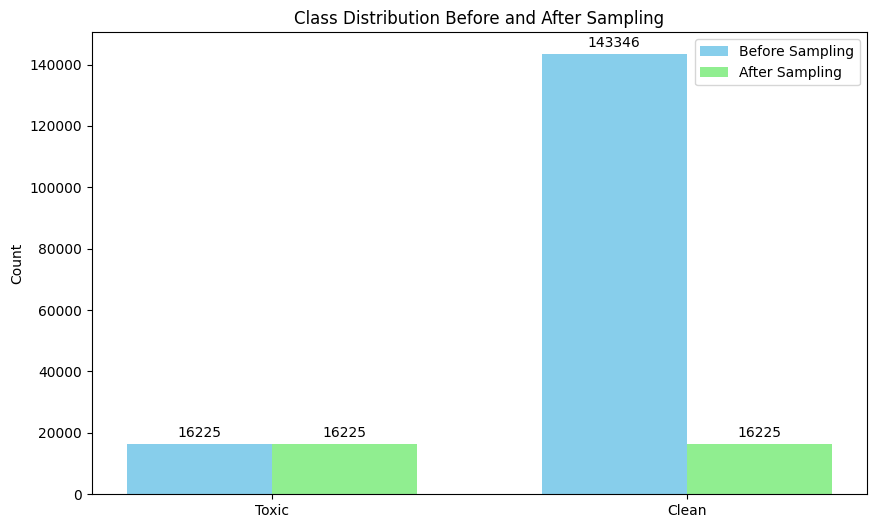

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the count of toxic and non-toxic comments before sampling
toxic_count_before = train_toxic.shape[0]
clean_count_before = train_clean.shape[0]

# Calculate the count of toxic and non-toxic comments after sampling
toxic_count_after = dataframe[dataframe[column_labels].sum(axis=1) > 0].shape[0]
clean_count_after = dataframe[dataframe[column_labels].sum(axis=1) == 0].shape[0]

# Data for plotting
labels = ['Toxic', 'Clean']
counts_before_sampling = [toxic_count_before, clean_count_before]
counts_after_sampling = [toxic_count_after, clean_count_after]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, counts_before_sampling, width, label='Before Sampling', color='skyblue')
rects2 = ax.bar(x + width/2, counts_after_sampling, width, label='After Sampling', color='lightgreen')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Class Distribution Before and After Sampling')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annotate bars with counts
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.show()


# Number of Comments Per Category - Class Imbalances

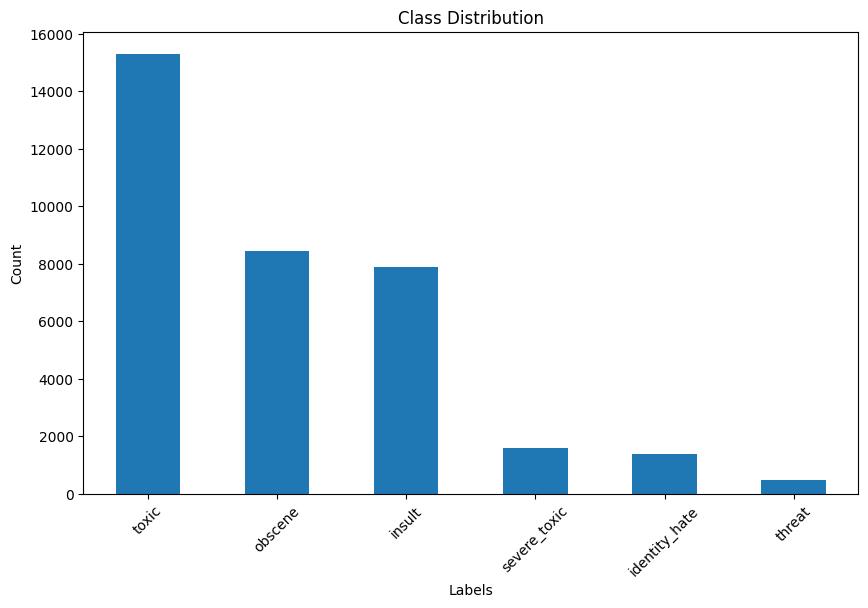

In [35]:
import matplotlib.pyplot as plt

# Plotting class distribution
plt.figure(figsize=(10, 6))
train_data[train_labels].sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


# Function to Calculate the Cross Validation Score

In [36]:
def cross_validation_score(classifier, X_train, y_train):
    '''
    Perform cross-validation for each label and compute F1, Recall, and Accuracy scores.
    
    Parameters:
    classifier (object): Machine learning classifier model.
    X_train (array-like): Training data features.
    y_train (DataFrame): Training data labels.
    
    Returns:
    list: List of lists containing evaluation metrics for each label.
    '''
    methods = []  # Initialize an empty list to store evaluation metrics
    name = classifier.__class__.__name__.split('.')[-1]  # Extract the name of the classifier
    
    # Iterate through each label in the training labels
    for label in train_labels:
        # Compute cross-validation scores for Recall, F1, and Accuracy using 5-fold cross-validation
        recall = cross_val_score(classifier, X_train, y_train[label], cv=5, scoring='recall')
        f1 = cross_val_score(classifier, X_train, y_train[label], cv=5, scoring='f1')
        acc = cross_val_score(classifier, X_train, y_train[label], cv=5, scoring='accuracy')
        
        # Compute mean scores across folds and store them in the methods list
        methods.append([name, label, recall.mean(), f1.mean(), acc.mean()])

    return methods

### Model 1: Multinomial Naive Bayes

In [37]:
# Advantage of the Multinomial Naive Bayes model

'''
An advantage of the Multinomial Naive Bayes model is its simplicity and efficiency in handling high-dimensional data, especially in text classification tasks like this. It assumes independence between features, making it computationally efficient and often performing well with relatively smaller training datasets compared to more complex models. Additionally, it tends to work well with sparse data, such as word frequencies in text data.
'''

'\nAn advantage of the Multinomial Naive Bayes model is its simplicity and efficiency in handling high-dimensional data, especially in text classification tasks like this. It assumes independence between features, making it computationally efficient and often performing well with relatively smaller training datasets compared to more complex models. Additionally, it tends to work well with sparse data, such as word frequencies in text data.\n'

In [38]:
# Initialize the Multinomial Naive Bayes classifier
NaiveBClf = MultinomialNB()

# Perform cross-validation for the Multinomial Naive Bayes model and obtain evaluation metrics
methods_cv = pd.DataFrame(cross_validation_score(NaiveBClf, X_train, dataframe))

# Assign appropriate column names to the dataframe
methods_cv.columns = ['Model', 'Label', 'Recall', 'F1', 'Accuracy']

# Reset the index of the dataframe
meth_cv = methods_cv.reset_index()


##### Displaying Evaluation Metrics Individually for Each Label for Model 1 - Multinomial Naive Bayes

In [39]:
display(meth_cv[['Model', 'Label', 'Recall', 'F1',"Accuracy"]])

,Model,Label,Recall,F1,Accuracy
0,MultinomialNB,toxic,0.859748,0.856585,0.864314
1,MultinomialNB,severe_toxic,0.017555,0.034155,0.951248
2,MultinomialNB,obscene,0.646468,0.722960,0.871002
3,MultinomialNB,threat,0.000000,0.000000,0.985239
4,MultinomialNB,insult,0.552367,0.635833,0.846410
5,MultinomialNB,identity_hate,0.027758,0.053653,0.957627


### Model 2: Logistic Regression

In [40]:
# Advantage of Logistic Regression model

'''
One of the advantages of Logistic Regression is its interpretability and ease of understanding. 
It provides probabilities for outcomes and can be particularly useful in scenarios where 
interpretability of model predictions is crucial. Additionally, it performs well in binary 
classification problems and can handle both linear and nonlinear relationships when used with 
appropriate feature engineering or transformations.
'''

'\nOne of the advantages of Logistic Regression is its interpretability and ease of understanding. \nIt provides probabilities for outcomes and can be particularly useful in scenarios where \ninterpretability of model predictions is crucial. Additionally, it performs well in binary \nclassification problems and can handle both linear and nonlinear relationships when used with \nappropriate feature engineering or transformations.\n'

In [41]:
# Initialize the Logistic Regression classifier with a maximum iteration of 1000
LogReg = LogisticRegression(max_iter=1000)

# Perform cross-validation for the Logistic Regression model and obtain evaluation metrics
methods_cv = pd.DataFrame(cross_validation_score(LogReg, X_train, dataframe))

# Assign appropriate column names to the dataframe
methods_cv.columns = ['Model', 'Label', 'Recall', 'F1', 'Accuracy']

# Reset the index of the dataframe
meth_cv = methods_cv.reset_index()


##### Displaying Evaluation Metrics Individually for Each Label for Model 2 - Logistic Regression

In [42]:
display(meth_cv[['Model', 'Label', 'Recall', 'F1',"Accuracy"]])

,Model,Label,Recall,F1,Accuracy
0,LogisticRegression,toxic,0.829737,0.863775,0.876672
1,LogisticRegression,severe_toxic,0.216928,0.311967,0.953097
2,LogisticRegression,obscene,0.668008,0.766553,0.894083
3,LogisticRegression,threat,0.136075,0.225389,0.986317
4,LogisticRegression,insult,0.565189,0.662339,0.860123
5,LogisticRegression,identity_hate,0.221352,0.336462,0.962219


### Answer:
##### Logistic Regression exhibits consistently higher F1-scores across all categories compared to Multinomial Naive Bayes (MultinomialNB).The superior F1-scores indicate Logistic Regression's better balance between precision and recall for each label. With higher recall values overall, Logistic Regression emerges as the preferred choice due to its superior performance in capturing both precision and recall across different categories.

## Multinomial Naive Bayes Model Metrics:

### toxic:
- Recall: 0.860
- F1-score: 0.857
- Accuracy: 0.864

### severe_toxic:
- Recall: 0.018
- F1-score: 0.034
- Accuracy: 0.951

### obscene:
-Recall: 0.646
-F1-score: 0.723
-Accuracy: 0.871

### threat:
- Recall: 0.000
- F1-score: 0.000
- Accuracy: 0.985

### insult:
- Recall: 0.552
- F1-score: 0.636
- Accuracy: 0.846

### identity_hate:
- Recall: 0.028
- F1-score: 0.054
- Accuracy: 0.958

## Logistic Regression Model Metrics:

### toxic:
- Recall: 0.830
- F1-score: 0.864
- Accuracy: 0.877

### severe_toxic:
- Recall: 0.217
- F1-score: 0.312
- Accuracy: 0.953

### obscene:
- Recall: 0.668
- F1-score: 0.767
- Accuracy: 0.894

### threat:
- Recall: 0.136
- F1-score: 0.225
- Accuracy: 0.986

### insult:
- Recall: 0.565
- F1-score: 0.662
- Accuracy: 0.860

### identity_hate:
- Recall: 0.221
- F1-score: 0.336
- Accuracy: 0.962

### Comparison:
Multinomial Naive Bayes vs. Logistic Regression:
For most categories (toxic, obscene, insult), Logistic Regression outperforms Multinomial Naive Bayes in terms of Recall, F1-score, and Accuracy.
Logistic Regression generally achieves higher Recall, F1-score, and Accuracy across multiple toxicity categories compared to Multinomial Naive Bayes.
Multinomial Naive Bayes tends to perform relatively poorly, especially in classes with limited data (severe_toxic, threat, identity_hate), showing lower Recall, F1-score, and Accuracy.

### Calculating the Evaluation Metrics for All Classes Individually and Overall for the TEST Dataset using the better of the two models - Logistic Regression

In [43]:
def score(classifier, X_train, y_train, X_test, y_test):
    """
    Calculate F1, Recall for each label on the test dataset using the provided classifier.
    """

    # Initialize an empty list to store evaluation metrics for each label
    methods = []

    # Extract the name of the classifier
    name = classifier.__class__.__name__.split('.')[-1]

    # Create an empty DataFrame to store predictions along with their corresponding IDs
    predict_df = pd.DataFrame()
    predict_df['id'] = y_test['id']

    # Iterate through each label in the training labels
    for label in train_labels:
        # Fit the classifier using the training data for the current label
        classifier.fit(X_train, y_train[label])
        
        # Make predictions on the test data
        predicted = classifier.predict(X_test)

        # Store predictions in the DataFrame under the current label
        predict_df[label] = predicted

        # Calculate recall, F1-score, confusion matrix, and accuracy for the current label
        recall = recall_score(y_test[y_test[label] != -1][label],
                              predicted[y_test[label] != -1],
                              average="weighted")
        f1 = f1_score(y_test[y_test[label] != -1][label],
                      predicted[y_test[label] != -1],
                      average="weighted")

        conf_mat = confusion_matrix(y_test[y_test[label] != -1][label],
                                    predicted[y_test[label] != -1])
        
        acc_l = accuracy_score(y_test[y_test[label] != -1][label],
                                    predicted[y_test[label] != -1])

        # Append the evaluation metrics to the 'methods' list
        methods.append([name, label, recall, f1, conf_mat, acc_l])

    # Return the list containing evaluation metrics for each label
    return methods


### Calculating Accuracy for Test Data using the Logistic Regression Model which is the better of the two model

In [44]:
methods = score(LogReg, X_train, dataframe, X_test, test_labels)
methods = pd.DataFrame(methods)
methods.columns = ['Model', 'Label', 'Recall', 'F1', 'Confusion_Matrix','acc']
meth = methods.reset_index()
display(meth[['Model', 'Label', 'Recall', 'F1','acc']])

,Model,Label,Recall,F1,acc
0,LogisticRegression,toxic,0.873597,0.892237,0.873597
1,LogisticRegression,severe_toxic,0.992935,0.992481,0.992935
2,LogisticRegression,obscene,0.964457,0.963895,0.964457
3,LogisticRegression,threat,0.996124,0.995629,0.996124
4,LogisticRegression,insult,0.963019,0.961663,0.963019
5,LogisticRegression,identity_hate,0.989918,0.988417,0.989918


### Testing on User Input Data

In [49]:
# Input sentence to classify
sentence1 = "Are you insane!"
sentence2 = "I will kill you nigga"

# Transform the input sentence1 using the previously defined TF-IDF vectorizer
demo1 = vector.transform([sentence1])
demo2 = vector.transform([sentence2])

# Dictionary to store predicted labels for the input sentence1
predict_df = {}

# Iterate through each label in the training labels
for label in train_labels:
    # Fit the Logistic Regression model for the current label on the entire training set
    LogReg.fit(X_train, dataframe[label])
   
    # Predict the label for the input sentence1 using the fitted model
    predicted = LogReg.predict(demo1)

    # Store the predicted label for the current class in the dictionary
    predict_df[label] = predicted[0]

# Display the input sentence1
print("Sentence1: \n", sentence1)

print("\nClassification:")
# Display the predicted labels for the input sentence1
for label, value in predict_df.items():
    # Capitalize and format the label for better readability
    label_formatted = ' '.join(word.capitalize() for word in label.split('_'))
    print(f"{label_formatted}: {value}")


# Dictionary to store predicted labels for the input sentence2
predict_df = {}

# Iterate through each label in the training labels
for label in train_labels:
    # Fit the Logistic Regression model for the current label on the entire training set
    LogReg.fit(X_train, dataframe[label])
   
    # Predict the label for the input sentence1 using the fitted model
    predicted = LogReg.predict(demo2)

    # Store the predicted label for the current class in the dictionary
    predict_df[label] = predicted[0]

# Display the input sentence1
print("\n\nSentence2: \n", sentence2)

print("\nClassification:")
# Display the predicted labels for the input sentence1
for label, value in predict_df.items():
    # Capitalize and format the label for better readability
    label_formatted = ' '.join(word.capitalize() for word in label.split('_'))
    print(f"{label_formatted}: {value}")


Sentence1: 
 Are you insane!

Classification:
Toxic: 1
Severe Toxic: 0
Obscene: 0
Threat: 0
Insult: 0
Identity Hate: 0


Sentence2: 
 I will kill you nigga

Classification:
Toxic: 1
Severe Toxic: 0
Obscene: 1
Threat: 0
Insult: 1
Identity Hate: 1


# SUGGESTED IMPROVEMENTS

Suggest potential improvements such as:
- Inclusion of more data to balance classes
- Techniques like oversampling or undersampling for handling class imbalance
- Exploring different models or hyperparameters
